In [29]:
import json
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler

torch.random.manual_seed(42)
np.random.seed(42)

from torchvision.transforms import v2
import torch.nn as nn
from tqdm import tqdm
import gc
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import random
import os
import numpy as np
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [30]:
def process_split(annotations_path, product_images_dir, logo_images_dir, output_prefix):
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)
    
    product_crops = []
    logo_arrays = []
    
    for product_filename in annotations:
        product_path = os.path.join(product_images_dir, product_filename)
        if not os.path.exists(product_path):
            print(f"Warning: Product image {product_filename} not found. Skipping.")
            continue
        
        try:
            product_img = Image.open(product_path).convert('RGB')
        except Exception as e:
            print(f"Error opening {product_filename}: {e}")
            continue
        
        for bbox, logo_filename in annotations[product_filename]:
            if logo_filename == "__unknown__":
                continue  
            
            logo_path = os.path.join(logo_images_dir, logo_filename)
            if not os.path.exists(logo_path):
                print(f"Warning: Logo image {logo_filename} not found. Skipping.")
                continue
            
            x1, y1, x2, y2 = map(int, bbox)
            img_width, img_height = product_img.size
            
            if (x1 >= x2 or y1 >= y2 or
                x1 < 0 or y1 < 0 or
                x2 > img_width or y2 > img_height):
                print(f"Invalid bbox {bbox} in {product_filename}. Skipping.")
                continue
            
            try:
                crop = product_img.crop((x1, y1, x2, y2))
            except Exception as e:
                print(f"Error cropping {product_filename}: {e}")
                continue
            
            crop_resized = crop.resize((128, 128), Image.Resampling.LANCZOS)
            crop_array = np.array(crop_resized, dtype=np.uint8)
            
            try:
                logo_img = Image.open(logo_path).convert('RGB')
            except Exception as e:
                print(f"Error opening logo {logo_filename}: {e}")
                continue
            
            logo_resized = logo_img.resize((128, 128), Image.Resampling.LANCZOS)
            logo_array = np.array(logo_resized, dtype=np.uint8)
            
            product_crops.append(crop_array)
            logo_arrays.append(logo_array)
    
    product_crops_np = np.array(product_crops)
    logo_arrays_np = np.array(logo_arrays)
    
    assert len(product_crops_np) == len(logo_arrays_np), "Mismatch in number of product crops and logo images."
    
    np.save(f"{output_prefix}_product_crops.npy", product_crops_np)
    np.save(f"{output_prefix}_logo_images.npy", logo_arrays_np)
    print(f"Saved {len(product_crops_np)} pairs for {output_prefix} split.")

    return product_crops_np, logo_arrays_np

In [31]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        self.embedding_dim = embedding_dim

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        for i in range(0, 7, 3):
            torch.nn.init.xavier_uniform_(self.conv_layers[i].weight)
            
        test_input = torch.randn(1, 3, 128, 128)
        test_output = self.conv_layers(test_input)
        flattened_size = np.prod(test_output.shape[1:])
        
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

        torch.nn.init.xavier_uniform_(self.fc_layers[0].weight)
        torch.nn.init.xavier_uniform_(self.fc_layers[2].weight)

    
    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x
        
    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

In [32]:
def contrastive_loss(output1, output2, target, margin=1.0):
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss = torch.mean(
        (1-target) * torch.pow(euclidean_distance, 2) +
        (target) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
    )
    return loss

In [33]:
class LogoDataset(Dataset):
    def __init__(self, product_crops_path, logo_images_path, transform=None):
        self.product_crops = np.load(product_crops_path)
        self.logo_images = np.load(logo_images_path)
        self.transform = transform

        assert len(self.product_crops) == len(self.logo_images), "Mismatch in number of product crops and logo images."

    def __len__(self):
        return len(self.product_crops)
        
    def __getitem__(self, index):
        crop_image = self.product_crops[index]
        logo_image = self.logo_images[index]

        crop_image = Image.fromarray(crop_image).convert("RGB")
        logo_image = Image.fromarray(logo_image).convert("RGB")

        if self.transform:
            crop_image = self.transform(crop_image)
            logo_image = self.transform(logo_image)
        
        return crop_image, logo_image

In [65]:
def train_siamese_network(model, train_loader, val_loader, n_epochs, threshold=0.5, device='cuda'):
    """
    Trains a Siamese network using vectorized operations to compute loss for the entire batch at once.
    Args:
        model (torch.nn.Module): The Siamese network model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (str): Device to train on ('cpu' or 'cuda').
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    
    for epoch in range(n_epochs):
        model.train()
        train_loss, total_pairs = 0.0, 0
        all_preds, all_labels = [], []
        
        for crops, logos in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            crops, logos = crops.to(device), logos.to(device)
            batch_size = crops.size(0)
            
            neg_logos = torch.roll(logos, shifts=1, dims=0)
            
            inputs1 = torch.cat([crops, crops], dim=0)
            inputs2 = torch.cat([logos, neg_logos], dim=0)
            labels = torch.cat([torch.zeros(batch_size), torch.ones(batch_size)], dim=0).to(device)
            
            emb1, emb2 = model(inputs1, inputs2)
            
            loss = contrastive_loss(emb1, emb2, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            distances = F.cosine_similarity(emb1, emb2, dim=1)
            preds = (distances > threshold).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
            train_loss += loss.item() * 2 * batch_size  # loss is sum, multiply by pairs
            total_pairs += 2 * batch_size
        
        avg_train_loss = train_loss / total_pairs
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss, val_pairs = 0.0, 0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for crops, logos in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                crops, logos = crops.to(device), logos.to(device)
                batch_size = crops.size(0)
                
                neg_logos = torch.roll(logos, shifts=1, dims=0)
                
                inputs1 = torch.cat([crops, crops], dim=0)
                inputs2 = torch.cat([logos, neg_logos], dim=0)
                labels = torch.cat([torch.zeros(batch_size), torch.ones(batch_size)], dim=0).to(device)
                
                emb1, emb2 = model(inputs1, inputs2)
                
                loss = contrastive_loss(emb1, emb2, labels)
                distances = F.cosine_similarity(emb1, emb2, dim=1)
                preds = (distances > threshold).long().cpu().numpy()
                
                val_loss += loss.item() * 2 * batch_size
                val_pairs += 2 * batch_size
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / val_pairs
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")
        if (epoch + 1) % 10 == 0:
            torch.save(model, f"model_{epoch+1}.pt")
    return model

In [42]:
def test_model(model, val_product_crops_path, val_logo_images_path, transform, device="cpu"):
    model.eval()

    product_crops = np.load(val_product_crops_path)
    logo_images = np.load(val_logo_images_path)

    num_samples = len(product_crops)
    y_true = []
    y_scores = []
    
    for i in range(num_samples):
        product_crop = Image.fromarray(product_crops[i]).convert("RGB")
        logo_img = Image.fromarray(logo_images[i]).convert("RGB")
        # plt.subplot(1, 2, 1)
        # plt.imshow(logo_img)
        # plt.subplot(1, 2, 2)
        # plt.imshow(product_crop)
        
        product_crop = transform(product_crop).to(device)
        logo_img = transform(logo_img).to(device)

        with torch.no_grad():
            output1, output2 = model(product_crop.unsqueeze(0), logo_img.unsqueeze(0))
            similarity = F.cosine_similarity(output1, output2).item()
        # plt.title(f"{similarity:.2f}")
        # plt.show()
        y_true.append(1)
        y_scores.append(similarity)

        neg_idx = (i + 1) % num_samples
        neg_product_crop = Image.fromarray(product_crops[i]).convert("RGB")
        neg_logo_img = Image.fromarray(logo_images[neg_idx]).convert("RGB")
        # plt.subplot(1, 2, 1)
        # plt.imshow(neg_logo_img)
        # plt.subplot(1, 2, 2)
        # plt.imshow(neg_product_crop)
        neg_product_crop = transform(neg_product_crop).to(device)
        neg_logo_img = transform(neg_logo_img).to(device)
        with torch.no_grad():
            output1, output2 = model(neg_product_crop.unsqueeze(0), neg_logo_img.unsqueeze(0))
            similarity = F.cosine_similarity(output1, output2).item()
            # plt.title(f"{similarity:.2f}")
            # plt.show()
        y_true.append(0)  # Negative
        y_scores.append(similarity)

    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Validation ROC AUC Score: {roc_auc:.4f}")
    return roc_auc, fpr, tpr, thresholds

In [36]:
product_images_dir = '/kaggle/input/osld-vk/osld1/product-images'
logo_images_dir = '/kaggle/input/osld-vk/osld1/logo-images'
annotations_dir = '/kaggle/input/osld-vk/osld1/annotations'

IMG_SIZE_PRODUCT = 128 
IMG_SIZE_LOGO = 128 
EMBEDDING_DIM = 128
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print("Preprocessing train split...")
train_crops, train_logos = process_split(
    annotations_path=os.path.join(annotations_dir, 'osld-train.json'),
    product_images_dir=product_images_dir,
    logo_images_dir=logo_images_dir,
    output_prefix='train'
)
print("Preprocessing validation split...")
val_product, val_logo = process_split(
    annotations_path=os.path.join(annotations_dir, 'osld-val.json'),
    product_images_dir=product_images_dir,
    logo_images_dir=logo_images_dir,
    output_prefix='val'
)

Preprocessing train split...
Invalid bbox [41, 239, 198, 278] in train00375.jpg. Skipping.
Invalid bbox [375, -1, 474, 54] in train00506.jpg. Skipping.
Invalid bbox [-2, 0, 105, 51] in train00891.jpg. Skipping.
Invalid bbox [169, -2, 263, 24] in train01640.jpg. Skipping.
Invalid bbox [178, -2, 317, 12] in train01770.jpg. Skipping.
Invalid bbox [14, -2, 93, 54] in train01830.jpg. Skipping.
Invalid bbox [-1, 170, 123, 234] in train02070.jpg. Skipping.
Invalid bbox [204, -2, 339, 60] in train02645.jpg. Skipping.
Invalid bbox [-2, 283, 50, 347] in train02657.jpg. Skipping.
Invalid bbox [340, 56, 503, 114] in train03075.jpg. Skipping.
Invalid bbox [-2, 184, 66, 221] in train03629.jpg. Skipping.
Invalid bbox [62, -8, 288, 140] in train03754.jpg. Skipping.
Invalid bbox [328, -1, 437, 62] in train03791.jpg. Skipping.
Invalid bbox [23, -2, 118, 67] in train05052.jpg. Skipping.
Invalid bbox [160, -4, 250, 85] in train05611.jpg. Skipping.
Invalid bbox [-3, 116, 35, 161] in train05708.jpg. Skippin

In [37]:
transform_product = transforms.Compose([
    transforms.Resize((IMG_SIZE_PRODUCT, IMG_SIZE_PRODUCT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_logo = transforms.Compose([
  transforms.Resize((IMG_SIZE_LOGO, IMG_SIZE_LOGO)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [66]:
train_dataset = LogoDataset(f"/kaggle/working/train_product_crops.npy", f"/kaggle/working/train_logo_images.npy", transform=transform)
val_dataset = LogoDataset(f"/kaggle/working/val_product_crops.npy", f"/kaggle/working/val_logo_images.npy", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = SiameseNetwork(embedding_dim=EMBEDDING_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [67]:
model = train_siamese_network(model, train_loader, val_loader, 10, threshold=0., device=device)

Epoch 1 Training: 100%|██████████| 725/725 [00:46<00:00, 15.57it/s]


Epoch 1, Train Loss: 0.2201


Epoch 1 Validation: 100%|██████████| 118/118 [00:03<00:00, 35.70it/s]


Epoch 1, Val Loss: 0.1893


Epoch 2 Training: 100%|██████████| 725/725 [00:46<00:00, 15.54it/s]


Epoch 2, Train Loss: 0.1565


Epoch 2 Validation: 100%|██████████| 118/118 [00:03<00:00, 35.88it/s]


Epoch 2, Val Loss: 0.1699


Epoch 3 Training: 100%|██████████| 725/725 [00:46<00:00, 15.63it/s]


Epoch 3, Train Loss: 0.1340


Epoch 3 Validation: 100%|██████████| 118/118 [00:03<00:00, 34.27it/s]


Epoch 3, Val Loss: 0.1709


Epoch 4 Training: 100%|██████████| 725/725 [00:46<00:00, 15.57it/s]


Epoch 4, Train Loss: 0.1180


Epoch 4 Validation: 100%|██████████| 118/118 [00:03<00:00, 35.29it/s]


Epoch 4, Val Loss: 0.1635


Epoch 5 Training: 100%|██████████| 725/725 [00:46<00:00, 15.53it/s]


Epoch 5, Train Loss: 0.1041


Epoch 5 Validation: 100%|██████████| 118/118 [00:03<00:00, 35.51it/s]


Epoch 5, Val Loss: 0.1640


Epoch 6 Training: 100%|██████████| 725/725 [00:46<00:00, 15.60it/s]


Epoch 6, Train Loss: 0.0942


Epoch 6 Validation: 100%|██████████| 118/118 [00:03<00:00, 35.61it/s]


Epoch 6, Val Loss: 0.1612


Epoch 7 Training: 100%|██████████| 725/725 [00:46<00:00, 15.56it/s]


Epoch 7, Train Loss: 0.0845


Epoch 7 Validation: 100%|██████████| 118/118 [00:03<00:00, 36.12it/s]


Epoch 7, Val Loss: 0.1636


Epoch 8 Training: 100%|██████████| 725/725 [00:46<00:00, 15.64it/s]


Epoch 8, Train Loss: 0.0767


Epoch 8 Validation: 100%|██████████| 118/118 [00:03<00:00, 36.07it/s]


Epoch 8, Val Loss: 0.1631


Epoch 9 Training: 100%|██████████| 725/725 [00:46<00:00, 15.64it/s]


Epoch 9, Train Loss: 0.0686


Epoch 9 Validation: 100%|██████████| 118/118 [00:03<00:00, 36.11it/s]


Epoch 9, Val Loss: 0.1673


Epoch 10 Training: 100%|██████████| 725/725 [00:46<00:00, 15.60it/s]


Epoch 10, Train Loss: 0.0623


Epoch 10 Validation: 100%|██████████| 118/118 [00:03<00:00, 34.61it/s]


Epoch 10, Val Loss: 0.1780


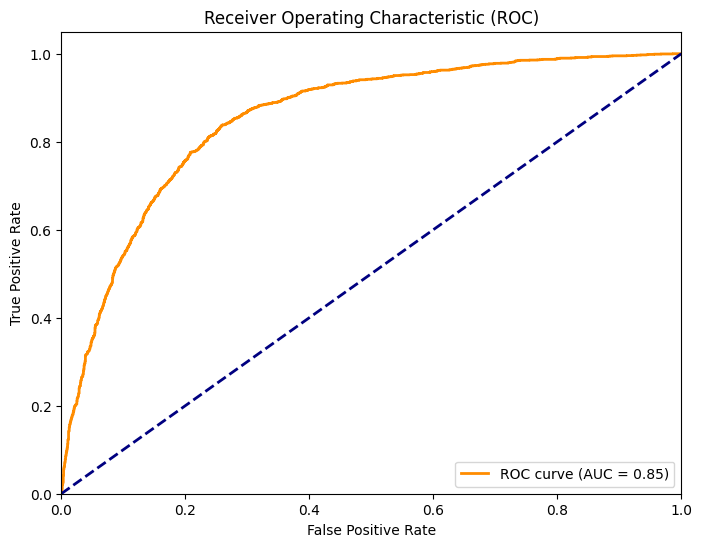

Validation ROC AUC Score: 0.8529


In [43]:
val_roc_auc, fpr, tpr, thresholds = test_model(model, f"val_product_crops.npy", f"val_logo_images.npy", transform, device=device)

In [53]:
test_product, test_logo = process_split(
    annotations_path=os.path.join(annotations_dir, 'osld-test.json'),
    product_images_dir=product_images_dir,
    logo_images_dir=logo_images_dir,
    output_prefix='test'
)
test_dataset = LogoDataset(f"/kaggle/working/test_product_crops.npy", f"/kaggle/working/test_logo_images.npy", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Invalid bbox [330, -3, 376, 76] in test00162.jpg. Skipping.
Invalid bbox [98, -4, 173, 107] in test00265.jpg. Skipping.
Invalid bbox [34, 184, 125, 282] in test00601.jpg. Skipping.
Invalid bbox [145, -1, 223, 31] in test01153.jpg. Skipping.
Invalid bbox [-3, 193, 50, 260] in test01408.jpg. Skipping.
Invalid bbox [23, 291, 209, 504] in test01408.jpg. Skipping.
Invalid bbox [65, -1, 218, 27] in test01484.jpg. Skipping.
Invalid bbox [271, -2, 349, 51] in test01494.jpg. Skipping.
Invalid bbox [276, -1, 350, 47] in test01663.jpg. Skipping.
Invalid bbox [284, 438, 344, 501] in test01843.jpg. Skipping.
Invalid bbox [-4, 336, 52, 406] in test02157.jpg. Skipping.
Invalid bbox [217, 423, 303, 503] in test02163.jpg. Skipping.
Invalid bbox [0, -1, 83, 78] in test02170.jpg. Skipping.
Saved 3197 pairs for test split.


In [57]:
def show_pics(model, prod_path, logo_path, transform, start, end, device="cpu"):
    model.eval()

    product_crops = np.load(prod_path)
    logo_images = np.load(logo_path)
    num_samples = end - start + 1
    for i in range(start, end):
        product_crop = Image.fromarray(product_crops[i]).convert("RGB")
        logo_img = Image.fromarray(logo_images[i]).convert("RGB")
        plt.subplot(1, 2, 1)
        plt.imshow(logo_img)
        plt.subplot(1, 2, 2)
        plt.imshow(product_crop)
        
        product_crop = transform(product_crop).to(device)
        logo_img = transform(logo_img).to(device)

        with torch.no_grad():
            output1, output2 = model(product_crop.unsqueeze(0), logo_img.unsqueeze(0))
            similarity = F.cosine_similarity(output1, output2).item()
            plt.title(f"{similarity:.2f}")
            plt.show()
        neg_idx = (i + 1) % num_samples
        neg_product_crop = Image.fromarray(product_crops[i]).convert("RGB")
        neg_logo_img = Image.fromarray(logo_images[neg_idx]).convert("RGB")
        plt.subplot(1, 2, 1)
        plt.imshow(neg_logo_img)
        plt.subplot(1, 2, 2)
        plt.imshow(neg_product_crop)
        neg_product_crop = transform(neg_product_crop).to(device)
        neg_logo_img = transform(neg_logo_img).to(device)
        with torch.no_grad():
            output1, output2 = model(neg_product_crop.unsqueeze(0), neg_logo_img.unsqueeze(0))
            similarity = F.cosine_similarity(output1, output2).item()
            plt.title(f"{similarity:.2f}")
            plt.show()

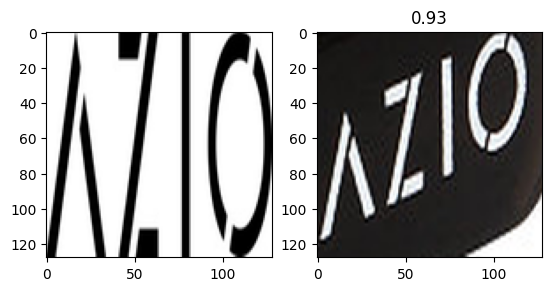

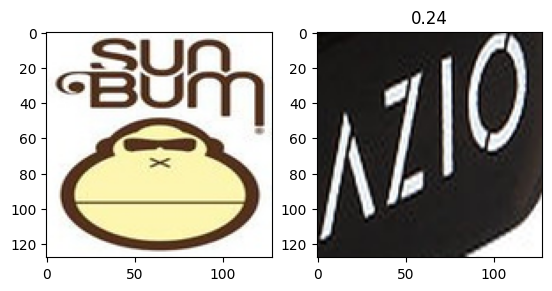

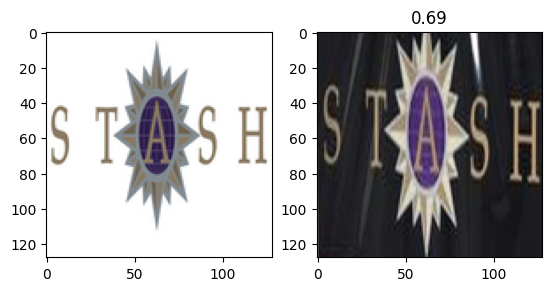

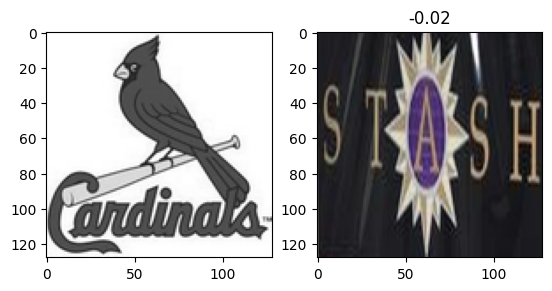

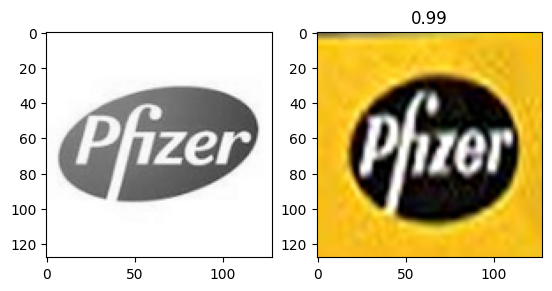

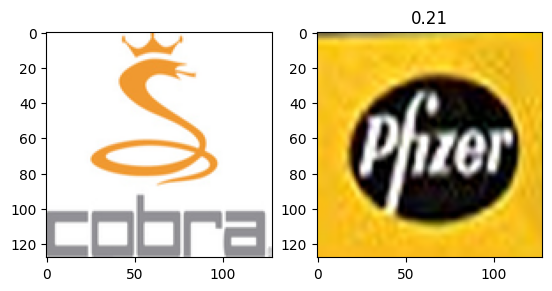

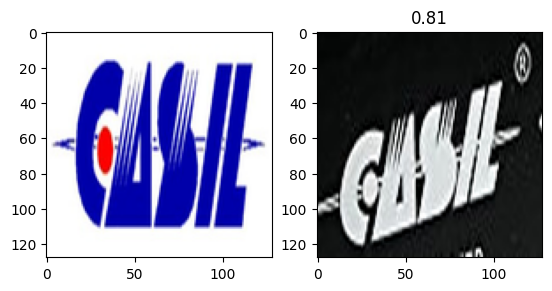

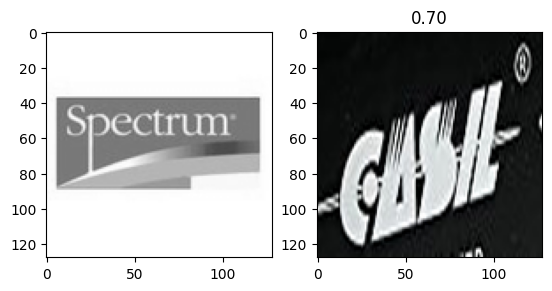

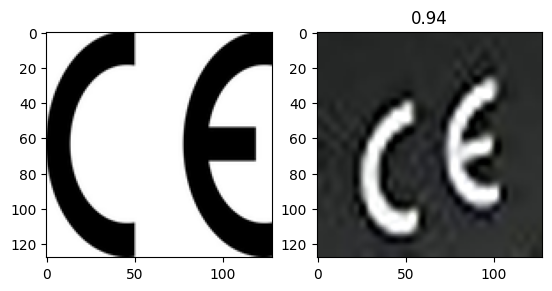

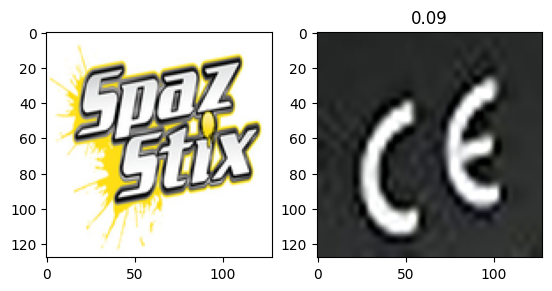

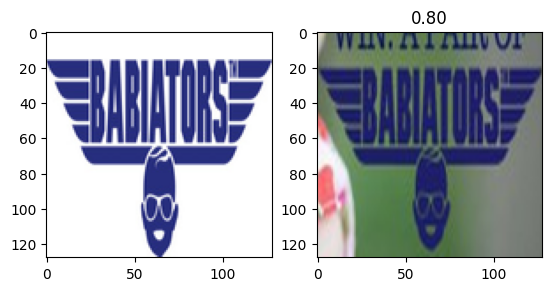

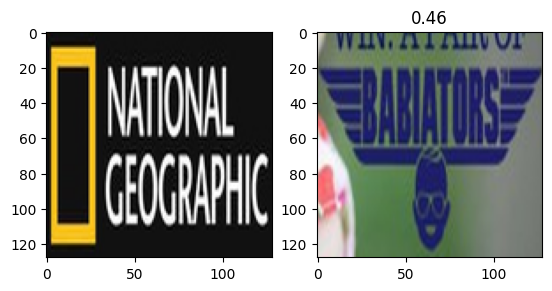

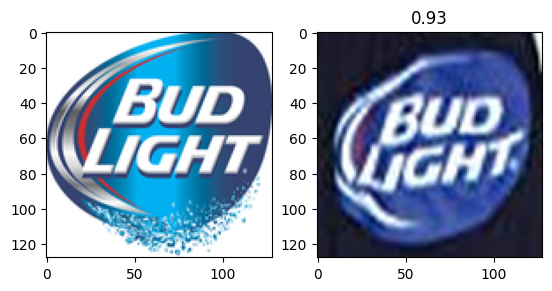

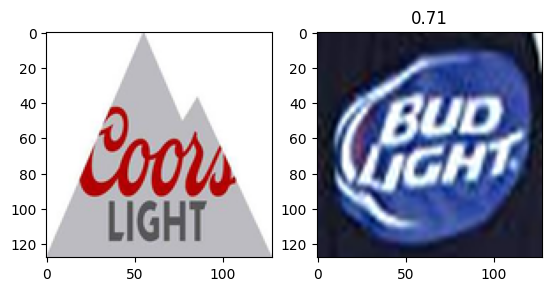

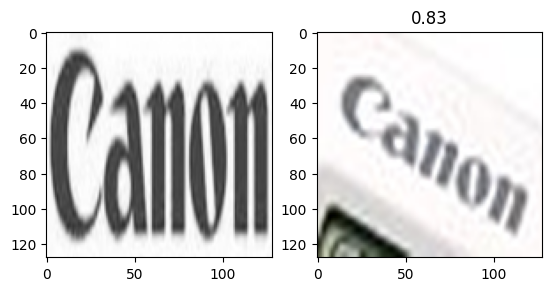

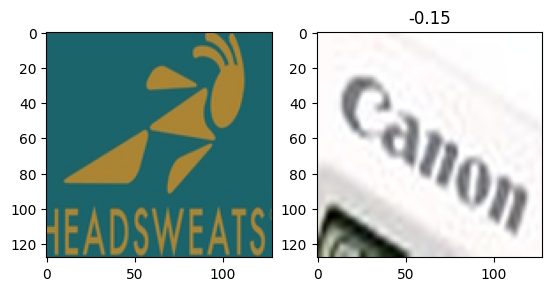

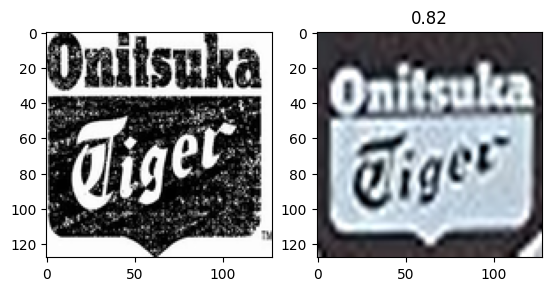

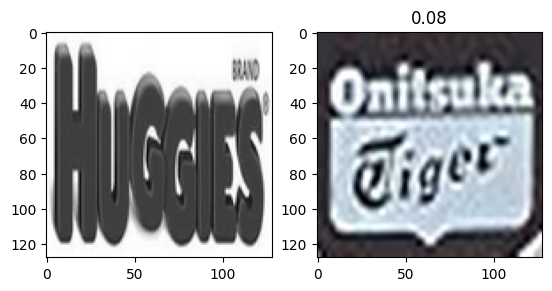

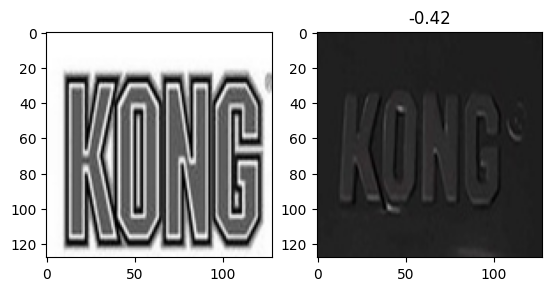

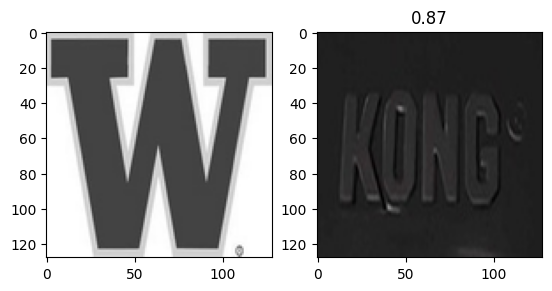

In [58]:
show_pics(model, f"test_product_crops.npy", f"test_logo_images.npy", transform, 10, 20, device=device)

In [ ]:
torch.save(model, 'model.pt')